In [1]:
import datetime
import matplotlib.pyplot as plt
from matplotlib import pyplot
import pandas as pd
import sklearn
from sklearn.datasets import load_diabetes
from sklearn.inspection import PartialDependenceDisplay
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
import numpy as np

pd.set_option("display.max_colwidth", 0)
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
import warnings
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.5f}'.format

In [2]:
# import sys
# import logging
# import datetime

# nblog = open("./output/catboost_pdp_shap_"+str(datetime.datetime.now())+".log", "a+")
# sys.stdout.echo = nblog
# sys.stderr.echo = nblog

# get_ipython().log.handlers[0].stream = nblog
# get_ipython().log.setLevel(logging.INFO)

# %autosave 5

In [4]:
%%time

df_traffic = pd.read_csv('./output/austin_2022_GP_10min_interval_delaydifference_with_features_forML.csv')
df_traffic['minutes_since_midnight'] = df_traffic['hour_min'].apply(lambda x: int(x[:2]) * 60 + int(x[3:]))

print(df_traffic.date.unique())
print('unique road segments (samples):',df_traffic.tmc_code.unique().shape[0])
print('total observations: ',df_traffic.shape[0])
df_traffic.head(2)

['2022-10-21' '2022-10-22' '2022-10-23']
unique road segments (samples): 4450
total observations:  1917950
CPU times: user 4.78 s, sys: 392 ms, total: 5.17 s
Wall time: 5.24 s


In [5]:
# because the event usually begins in the morning after 10, people arrive typically around that time, so we want to only focus on after 930
df_traffic = df_traffic[df_traffic['minutes_since_midnight']>=540]
print(df_traffic.shape[0])

1197050


In [6]:
df_traffic.columns

Index(['tmc_code', 'hour_min', 'delay_baseline', 'delay_focus', 'delay_difference', 'date', 'intersection', 'start_latitude', 'start_longitude', 'end_latitude', 'end_longitude', 'miles', 'airbnb_count', 'distance_to_Shuttle_Waterloo_Park', 'distance_to_Shuttle_Barton_Creek_Square', 'distance_to_Shuttle_Expo_Center', 'distance_to_Uber_DelValle_HighSchool', 'distance_to_venue', 'minutes_since_midnight'], dtype='object')

In [19]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Prepare input features and labels for the model
X = df_traffic[['minutes_since_midnight',  'start_latitude', 'start_longitude', 'miles', 
                          'airbnb_count', 'distance_to_Shuttle_Waterloo_Park', 'distance_to_Shuttle_Barton_Creek_Square', 
                          'distance_to_Shuttle_Expo_Center', 'distance_to_Uber_DelValle_HighSchool', 'distance_to_venue']].copy()
y = df_traffic['delay_difference'].values

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print('Total sample size:', X.shape[0])
print('Total training set size:', X_train.shape[0])
print('Total test set size:', X_test.shape[0])

Total sample size: 1197050
Total training set size: 837935
Total test set size: 359115


In [23]:
%%time
# check VIF

df_cor = X.corr()
display(pd.DataFrame(np.linalg.inv(X.corr().values), index = df_cor.index, columns=df_cor.columns))

,minutes_since_midnight,start_latitude,start_longitude,miles,airbnb_count,distance_to_Shuttle_Waterloo_Park,distance_to_Shuttle_Barton_Creek_Square,distance_to_Shuttle_Expo_Center,distance_to_Uber_DelValle_HighSchool,distance_to_venue
minutes_since_midnight,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-0.00000,-0.00000,0.00000,-0.00000
start_latitude,0.00000,16.66550,-0.25938,0.81057,0.23729,2.53443,-0.58231,0.53332,32.09939,-47.84499
start_longitude,0.00000,-0.25938,5.33612,0.29394,-0.38134,-0.90740,-5.82432,-0.41746,18.09198,-13.01078
miles,0.00000,0.81057,0.29394,1.25955,-0.14218,-1.03468,-0.02651,-0.00539,2.77891,-2.86867
airbnb_count,0.00000,0.23729,-0.38134,-0.14218,1.70781,5.98059,-3.08213,-2.44925,1.00674,-1.28450
distance_to_Shuttle_Waterloo_Park,0.00000,2.53443,-0.90740,-1.03468,5.98059,74.45623,-50.27565,-22.59948,-18.79238,13.87097
distance_to_Shuttle_Barton_Creek_Square,-0.00000,-0.58231,-5.82432,-0.02651,-3.08213,-50.27565,46.38830,10.13752,15.60473,-18.15437
distance_to_Shuttle_Expo_Center,-0.00000,0.53332,-0.41746,-0.00539,-2.44925,-22.59948,10.13752,30.04414,-80.51961,68.04435
distance_to_Uber_DelValle_HighSchool,0.00000,32.09939,18.09198,2.77891,1.00674,-18.79238,15.60473,-80.51961,490.46505,-456.83537
distance_to_venue,-0.00000,-47.84499,-13.01078,-2.86867,-1.28450,13.87097,-18.15437,68.04435,-456.83537,451.65480


CPU times: user 593 ms, sys: 128 ms, total: 721 ms
Wall time: 556 ms


# autogluon

In [ ]:
%%time

from autogluon.tabular import TabularDataset, TabularPredictor

train_data = X_train.copy()
train_data['delay_difference'] = y_train
test_data = X_test.copy()
test_data['delay_difference'] = y_test

predictor = TabularPredictor(label='delay_difference', problem_type='regression').fit(train_data=train_data)

No path specified. Models will be saved in: "AutogluonModels/ag-20241113_155843/"
	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20241113_155843/"
AutoGluon Version:  0.6.2
Python Version:     3.7.1
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #167~18.04.1-Ubuntu SMP Wed May 24 00:51:42 UTC 2023
Train Data Rows:    837935
Train Data Columns: 11
Label Column: delay_difference
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    50730.77 MB
	Train Data (Original)  Memory Usage: 123.18 MB (0.2% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify speci

[1000]	valid_set's rmse: 16.9784
[2000]	valid_set's rmse: 16.6083
[3000]	valid_set's rmse: 16.4002
[4000]	valid_set's rmse: 16.2711
[5000]	valid_set's rmse: 16.1805
[6000]	valid_set's rmse: 16.1118
[7000]	valid_set's rmse: 16.066
[8000]	valid_set's rmse: 16.0117
[9000]	valid_set's rmse: 15.9741
[10000]	valid_set's rmse: 15.9271


	-15.9264	 = Validation score   (-root_mean_squared_error)
	115.01s	 = Training   runtime
	0.85s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's rmse: 13.961
[2000]	valid_set's rmse: 13.6242
[3000]	valid_set's rmse: 13.3804
[4000]	valid_set's rmse: 13.3419
[5000]	valid_set's rmse: 13.2379
[6000]	valid_set's rmse: 13.1914
[7000]	valid_set's rmse: 13.1202
[8000]	valid_set's rmse: 13.1044
[9000]	valid_set's rmse: 13.0514
[10000]	valid_set's rmse: 13.0163


	-13.0162	 = Validation score   (-root_mean_squared_error)
	53.06s	 = Training   runtime
	0.78s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-10.9971	 = Validation score   (-root_mean_squared_error)
	168.04s	 = Training   runtime
	0.21s	 = Validation runtime
Fitting model: CatBoost ...
	-14.0824	 = Validation score   (-root_mean_squared_error)
	259.37s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-11.6505	 = Validation score   (-root_mean_squared_error)
	54.91s	 = Training   runtime
	0.13s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
No improvement since epoch 2: early stopping
	-18.0202	 = Validation score   (-root_mean_squared_error)
	296.55s	 = Training   runtime
	0.19s	 = Validation runtime
Fitting model: XGBoost ...
	-12.7443	 = Validation score   (-root_mean_squared_error)
	134.83s	 = Training   runtime
	0.7s	 = Validation runtime
Fitting model: NeuralNetTorch ...


In [16]:
print(datetime.datetime.now(),'************** Running predictor.leaderboard **************')
fittedmodels_eval = predictor.leaderboard(test_data, silent=True)
print(fittedmodels_eval)
print(datetime.datetime.now(),'************** Done predictor.leaderboard **************')
# The results indicate that ExtraTreesMSE, WeightedEnsemble_L2, RandomForestMSE are the best models

2024-11-13 15:14:00.413517 ************** Running predictor.leaderboard **************
                  model  score_test  score_val  pred_time_test  pred_time_val   fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0         ExtraTreesMSE   -11.66775  -11.65050         3.77813        0.12646   54.91256                  3.77813                 0.12646           54.91256            1       True          7
1   WeightedEnsemble_L2   -11.89815  -10.98360        19.74013        0.65261  225.84913                  0.02163                 0.00042            0.28581            2       True         12
2       RandomForestMSE   -11.97616  -10.99712         3.96479        0.21448  168.04052                  3.96479                 0.21448          168.04052            1       True          5
3         LightGBMLarge   -12.59284  -11.80432        25.13703        0.62119   82.24266                 25.13703                 0.62119        

# Hyperparameter tuning using optuna

In [ ]:
# %%time
# # %pip install optuna
# ## this step took 10 hours to finish

# import optuna
# from sklearn.model_selection import cross_val_score, KFold
# from sklearn.metrics import make_scorer, mean_squared_error

# def objective(trial):
#     # Define hyperparameters to optimize
#     params = {
#         'iterations': trial.suggest_int('iterations', 100, 1200, step=100),
#         'max_depth': trial.suggest_int('depth', 4, 12),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.3),
#         "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
#         "subsample": trial.suggest_float("subsample", 0.05, 1.0),
#         "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
#         'loss_function': 'RMSE','eval_metric': 'RMSE'
#     }

#     # Initialize CatBoostRegressor with the suggested hyperparameters
#     model = cb.CatBoostRegressor(cat_features=categorical_list, **params, verbose=0)
    
#     # Perform cross-validation
#     kf = KFold(n_splits=5, shuffle=True, random_state=42)
# #     kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
#     rmse_scorer = make_scorer(mean_squared_error, squared=False)
#     scores = cross_val_score(model, X_train, y_train, cv=kf, scoring=rmse_scorer)

#     return scores.mean()

# # Create a study and optimize the objective function
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=50)

# Training

In [30]:
# ## Define XGBoost model

# # regressor = xgb.XGBRegressor(objective='reg:squarederror', 
# #                          n_estimators=100,
# #                          eval_metric='rmse'
# #                          )#early_stopping_rounds=100,  learning_rate=0.01, 
                         
# # regressor.fit(X_train, y_train, 
# #           eval_set=[(X_test, y_test)],
# #           verbose=True)

# # # Make predictions
# # y_pred = regressor.predict(X_test)

# from sklearn.preprocessing import StandardScaler
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.metrics import mean_squared_error, r2_score

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# # Initialize KNeighborsRegressor
# knn = KNeighborsRegressor(n_neighbors=10) #weights='distance',

# # Train the model
# knn.fit(X_train, y_train)

# # Make predictions
# y_pred = knn.predict(X_test)

# # Evaluate the model
# print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
# print("R-squared:", r2_score(y_test, y_pred))

Mean Squared Error: 291.4811698258217
R-squared: 0.2899376830726337


# Model evaluation

In [94]:
# # Calculate and print the mean squared error
# mse = mean_squared_error(y_test, y_pred)
# print(f'Mean Squared Error: {mse}')

# # Compute R^2 score
# r2 = r2_score(y_test, y_pred)
# print(f'R^2 score: {r2:.4f}')

Mean Squared Error: 317.77472197052606
R^2 score: 0.2259


# SHAP

2024-11-13 10:43:12.324103 *************** Start running SHAP importance ***************
2024-11-13 10:43:12.620145 *************** Done running SHAP importance ***************
CPU times: user 123 ms, sys: 177 ms, total: 300 ms
Wall time: 296 ms


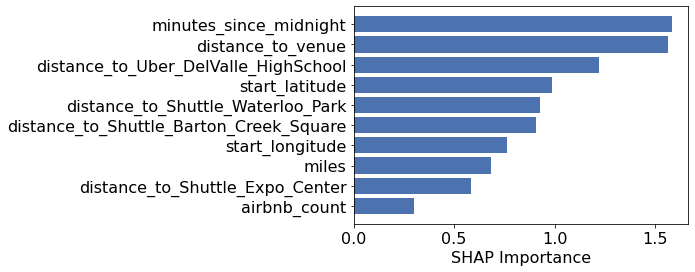

In [96]:
# %%time
# print(datetime.datetime.now(),'*************** Start running SHAP importance ***************')
# plt.rcParams.update({'font.size': 16})
# fig, ax = plt.subplots(1,1)  #,figsize=(6,9)
# shap_importance = shap_values.abs.mean(0).values
# sorted_idx = shap_importance.argsort()
# plt.barh(range(len(sorted_idx)), shap_importance[sorted_idx], align='center',color="#4c72b0") #'turquoise'
# plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
# plt.xlabel('SHAP Importance')
# # plt.savefig('./output/feature_importance_shap.pdf', bbox_inches='tight')
# print(datetime.datetime.now(),'*************** Done running SHAP importance ***************')